In [50]:
import os
os.chdir("C:/Users/nickl/OneDrive/Documents")

In [51]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error


In [52]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense

In [53]:
df = pd.read_csv("BTC.csv")


In [54]:
df.head()

,ticker,date,open,high,low,close
0,BTC,2010-07-17,0.04951,0.04951,0.04951,0.04951
1,BTC,2010-07-18,0.04951,0.08585,0.04951,0.08584
2,BTC,2010-07-19,0.08584,0.09307,0.07723,0.08080
3,BTC,2010-07-20,0.08080,0.08181,0.07426,0.07474
4,BTC,2010-07-21,0.07474,0.07921,0.06634,0.07921


In [55]:
cutoff_date = '2025-01-01'

# Filter the DataFrame
df = df[df['date'] < cutoff_date]

In [56]:
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date')

features = ['open', 'high', 'low', 'close']
data = df[features].values

scaler = MinMaxScaler()
data = scaler.fit_transform(data)

SEQ_LEN = 10

# Define split point
split_index = int(0.9 * len(data))

# Training set
train_data = data[:split_index]
X_train, y_train = [], []
for i in range(len(train_data) - SEQ_LEN):
    X_train.append(train_data[i:i+SEQ_LEN])
    y_train.append(train_data[i+SEQ_LEN, 3])  # Close price

# Testing set
test_data = data[split_index-SEQ_LEN:]  # start a bit earlier so we can build sequences
X_test, y_test = [], []
for i in range(len(test_data) - SEQ_LEN):
    X_test.append(test_data[i:i+SEQ_LEN])
    y_test.append(test_data[i+SEQ_LEN, 3])

X_train, y_train = np.array(X_train), np.array(y_train)
X_test, y_test = np.array(X_test), np.array(y_test)

# Build and train model
model = Sequential([
    GRU(64, input_shape=(SEQ_LEN, len(features))),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.summary()

model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test))

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_5 (GRU)                 (None, 64)                13440     
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 13505 (52.75 KB)
Trainable params: 13505 (52.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/30
148/148 [==============================] - 2s 5ms/step - loss: 8.6663e-04 - val_loss: 4.5142e-04
Epoch 2/30
148/148 [==============================] - 0s 3ms/step - loss: 8.9510e-05 - val_loss: 7.0981e-04
Epoch 3/30
148/148 [==============================] - 0s 3ms/step - loss: 8.5014e-05 - val_loss: 4.0306e-04
Epoch 4/30
148/148 [==============================] - 0s 3ms/step - loss: 7.6651e-05 - val

In [57]:
predicted = model.predict(X_test)

# Inverse transform
# Again, need to pad with zeros for Open/High/Low
predicted_full = np.hstack((np.zeros((predicted.shape[0], 3)), predicted))
predicted_close = scaler.inverse_transform(predicted_full)[:, 3]

# Same for true y_test
y_test_full = np.hstack((np.zeros((y_test.shape[0], 3)), y_test.reshape(-1, 1)))
true_close = scaler.inverse_transform(y_test_full)[:, 3]

17/17 [==============================] - 0s 1ms/step


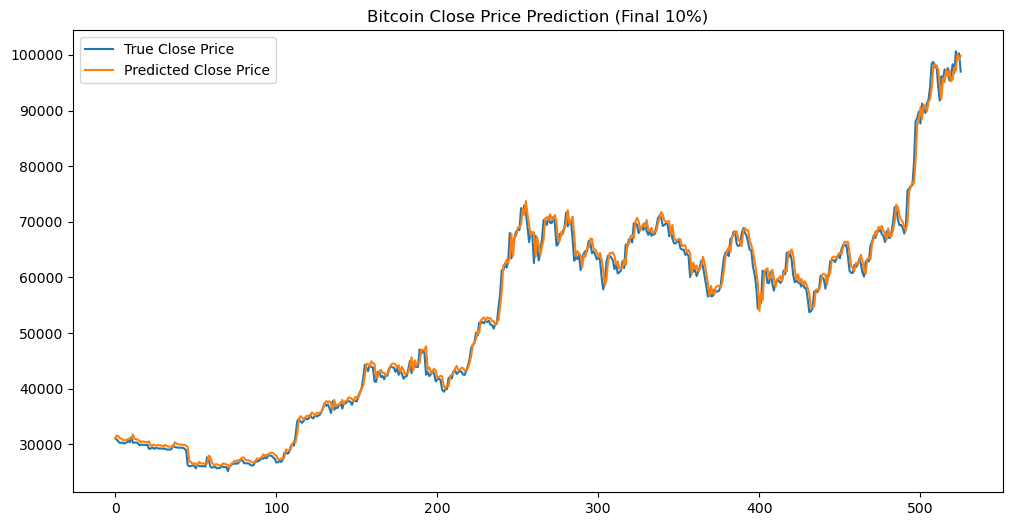

In [58]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(true_close, label='True Close Price')
plt.plot(predicted_close, label='Predicted Close Price')
plt.legend()
plt.title('Bitcoin Close Price Prediction (Final 10%)')
plt.show()


In [59]:


predicted_close = target_scaler.inverse_transform(predicted)

# Reshape y_test to 2D (it is currently 1D, hence the error)
true_close = target_scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(true_close, predicted_close)

# Print the MSE value
print(f'Mean Squared Error (MSE): {mse}')



Mean Squared Error (MSE): 0.00120989511191395


In [60]:


# Load data
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date')

# Select only Open, High, Low as features
features = ['open', 'high', 'low']
target = 'close'

# Scale features and target separately
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

feature_data = feature_scaler.fit_transform(df[features].values.reshape(-1, len(features)))
target_data = target_scaler.fit_transform(df[[target]].values)  # Double brackets [[]] keep it 2D

SEQ_LEN = 10

# Define split
split_index = int(0.9 * len(df))

# Training set
train_features = feature_data[:split_index]
train_target = target_data[:split_index]

X_train, y_train = [], []
for i in range(len(train_features) - SEQ_LEN):
    X_train.append(train_features[i:i+SEQ_LEN])
    y_train.append(train_target[i+SEQ_LEN])

# Testing set
test_features = feature_data[split_index-SEQ_LEN:]  # go back SEQ_LEN to build sequences
test_target = target_data[split_index-SEQ_LEN:]

X_test, y_test = [], []
for i in range(len(test_features) - SEQ_LEN):
    X_test.append(test_features[i:i+SEQ_LEN])
    y_test.append(test_target[i+SEQ_LEN])

X_train, y_train = np.array(X_train), np.array(y_train)
X_test, y_test = np.array(X_test), np.array(y_test)

# Build and compile model
model = Sequential([
    GRU(64, input_shape=(SEQ_LEN, len(features))),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.summary()

# Train
model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test))


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_6 (GRU)                 (None, 64)                13248     
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 13313 (52.00 KB)
Trainable params: 13313 (52.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/30
148/148 [==============================] - 2s 5ms/step - loss: 0.0024 - val_loss: 6.5552e-04
Epoch 2/30
148/148 [==============================] - 0s 3ms/step - loss: 1.0915e-04 - val_loss: 5.5618e-04
Epoch 3/30
148/148 [==============================] - 0s 3ms/step - loss: 1.0580e-04 - val_loss: 4.7387e-04
Epoch 4/30
148/148 [==============================] - 0s 3ms/step - loss: 9.7436e-05 - val_los

17/17 [==============================] - 0s 2ms/step


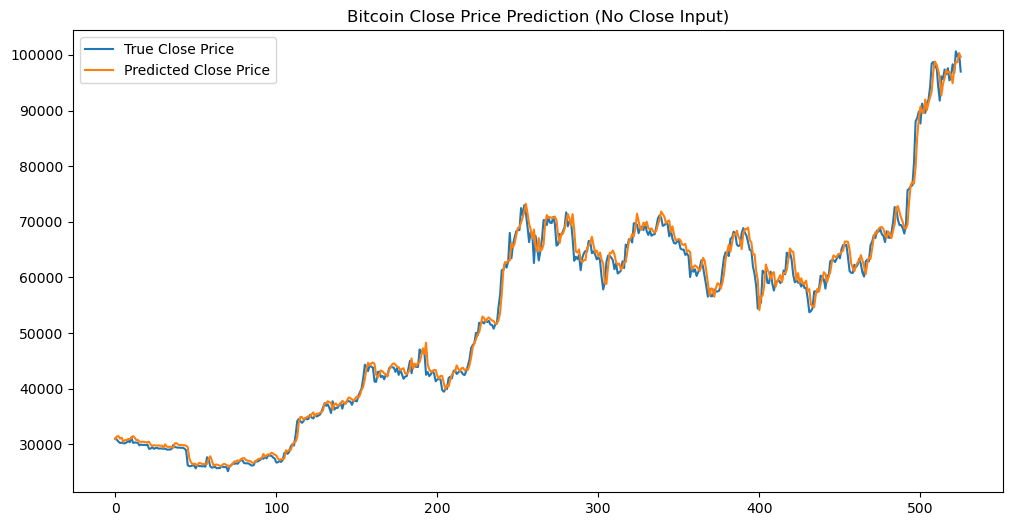

In [61]:
# Predict
predicted = model.predict(X_test)

# Recover actual Close prices
predicted_close = target_scaler.inverse_transform(predicted)
true_close = target_scaler.inverse_transform(y_test)

# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(true_close, label='True Close Price')
plt.plot(predicted_close, label='Predicted Close Price')
plt.legend()
plt.title('Bitcoin Close Price Prediction (No Close Input)')
plt.show()


In [62]:
from sklearn.metrics import mean_absolute_error



# Calculate MSE
mae = mean_absolute_error(true_close, predicted_close)

# Print the MSE value
print(f'Mean Absolute Error (MSE): {mae}')

Mean Absolute Error (MSE): 1135.934432182747


In [63]:
epsilon = 1e-8  # small value to avoid log(0)

relative_diff = (df['close']/ df['close'].shift(1))
relative_diff = relative_diff.clip(lower=epsilon)  # avoid negatives or zeros
log_of_relative_diff = np.log(relative_diff)

# If you want to add it back into the DataFrame as a new column:
df['returns'] = log_of_relative_diff

In [64]:
df.shape

(5260, 7)

In [65]:
df.dropna()

,ticker,date,open,high,low,close,returns
1,BTC,2010-07-18,0.04951,0.08585,0.04951,0.08584,0.550310
2,BTC,2010-07-19,0.08584,0.09307,0.07723,0.08080,-0.060508
3,BTC,2010-07-20,0.08080,0.08181,0.07426,0.07474,-0.077962
4,BTC,2010-07-21,0.07474,0.07921,0.06634,0.07921,0.058087
5,BTC,2010-07-22,0.07921,0.08181,0.05050,0.05050,-0.450129
...,...,...,...,...,...,...,...
5255,BTC,2024-12-05,98298.20000,104062.00000,93081.30000,96751.80000,-0.015999
5256,BTC,2024-12-06,96789.00000,102079.00000,95560.60000,100648.00000,0.039480
5257,BTC,2024-12-07,100648.00000,100724.00000,99087.60000,99717.70000,-0.009286
5258,BTC,2024-12-08,99717.70000,100548.00000,98767.20000,100276.00000,0.005583


In [66]:

# Load data
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date')

# Select only Open, High, Low as features
features = ['open', 'high', 'low', 'close']
target = 'returns'

# Scale features and target separately
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

feature_data = feature_scaler.fit_transform(df[features].values.reshape(-1, len(features)))
target_data = target_scaler.fit_transform(df[[target]].values)  # Double brackets [[]] keep it 2D

SEQ_LEN = 10

# Define split
split_index = int(0.9 * len(df))

# Training set
train_features = feature_data[:split_index]
train_target = target_data[:split_index]

X_train, y_train = [], []
for i in range(len(train_features) - SEQ_LEN):
    X_train.append(train_features[i:i+SEQ_LEN])
    y_train.append(train_target[i+SEQ_LEN])

# Testing set
test_features = feature_data[split_index-SEQ_LEN:]  # go back SEQ_LEN to build sequences
test_target = target_data[split_index-SEQ_LEN:]

X_test, y_test = [], []
for i in range(len(test_features) - SEQ_LEN):
    X_test.append(test_features[i:i+SEQ_LEN])
    y_test.append(test_target[i+SEQ_LEN])

X_train, y_train = np.array(X_train), np.array(y_train)
X_test, y_test = np.array(X_test), np.array(y_test)

# Build and compile model
model = Sequential([
    GRU(64, input_shape=(SEQ_LEN, len(features))),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.summary()

# Train
model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test))


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_7 (GRU)                 (None, 64)                13440     
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 13505 (52.75 KB)
Trainable params: 13505 (52.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/30
148/148 [==============================] - 2s 5ms/step - loss: 0.0090 - val_loss: 1.1977e-04
Epoch 2/30
148/148 [==============================] - 0s 3ms/step - loss: 6.3122e-04 - val_loss: 1.5638e-04
Epoch 3/30
148/148 [==============================] - 1s 4ms/step - loss: 6.3055e-04 - val_loss: 1.3322e-04
Epoch 4/30
148/148 [==============================] - 0s 3ms/step - loss: 6.3581e-04 - val_los

17/17 [==============================] - 0s 2ms/step


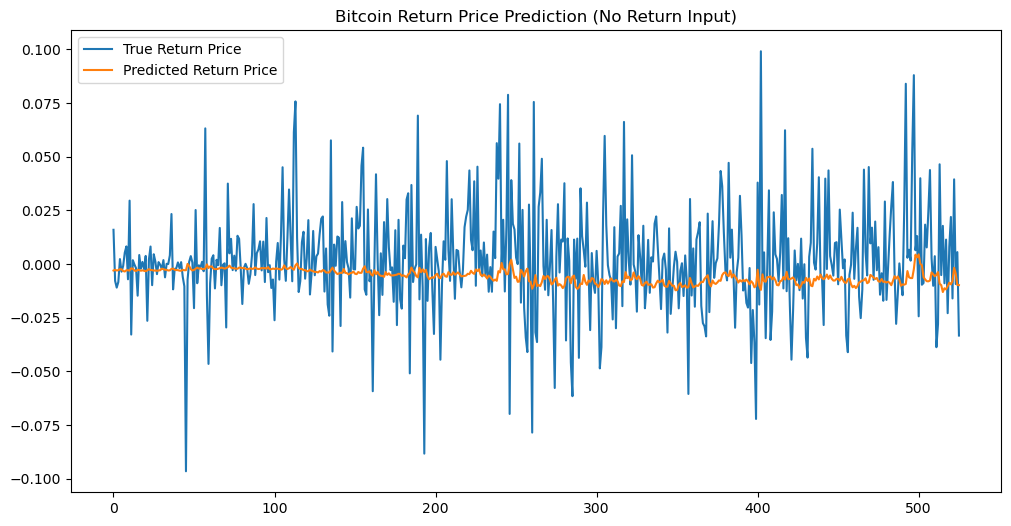

In [67]:
# Predict
predicted = model.predict(X_test)

# Recover actual Close prices
predicted_close = target_scaler.inverse_transform(predicted)
true_close = target_scaler.inverse_transform(y_test)

# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(true_close, label='True Return Price')
plt.plot(predicted_close, label='Predicted Return Price')
plt.legend()
plt.title('Bitcoin Return Price Prediction (No Return Input)')
plt.show()


In [68]:
# Calculate MSE
mae = mean_absolute_error(true_close, predicted_close)

# Print the MSE value
print(f'Mean Absolute Error (MSE): {mae}')

Mean Absolute Error (MSE): 0.0182960209169521


In [69]:
from sklearn.metrics import r2_score

In [70]:
r_squared = r2_score(true_close, predicted_close)
print(r_squared)

-0.11278548032486468


In [71]:
pip install statsmodels pandas numpy matplotlib


Note: you may need to restart the kernel to use updated packages.


In [72]:
# Determine the split point
train_size = int(len(df) * 0.9)

# Split the data into training and test sets
train, test = df['returns'][:train_size], df['returns'][train_size:]


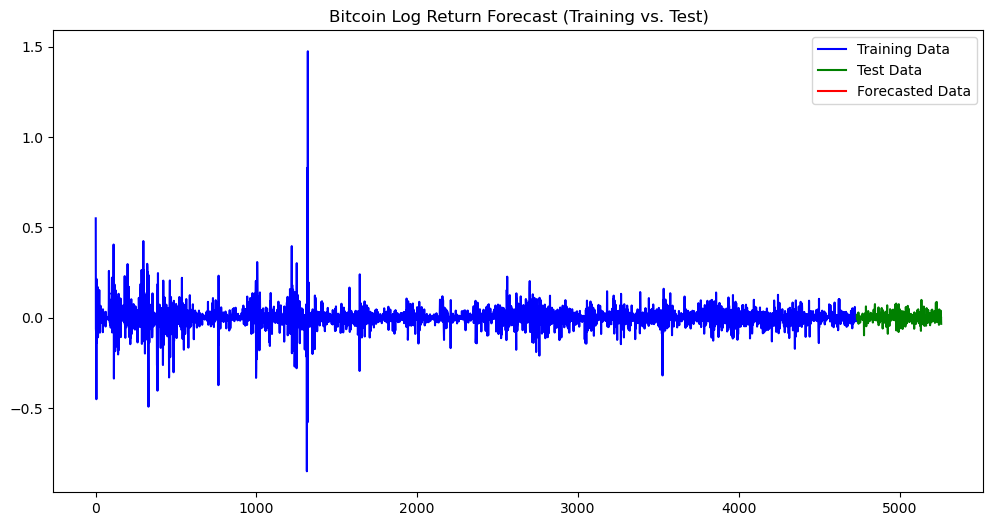

In [73]:
from statsmodels.tsa.arima.model import ARIMA

# Fit ARIMA model on training data
model = ARIMA(train, order=(1, 0, 1))  # You can adjust (p, d, q) based on your earlier steps
model_fit = model.fit()

# Forecast the next 10% (test set) of the data
forecast = model_fit.forecast(steps=len(test))

# Create a DataFrame for the forecasted values
forecast_index = test.index  # Use the same index as the test data for proper alignment
forecast_df = pd.DataFrame(forecast, index=forecast_index, columns=['forecast'])

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Training Data', color='blue')
plt.plot(test.index, test, label='Test Data', color='green')
plt.plot(forecast_df.index, forecast_df['forecast'], label='Forecasted Data', color='red')
plt.legend()
plt.title('Bitcoin Log Return Forecast (Training vs. Test)')
plt.show()


In [74]:
from sklearn.metrics import r2_score

# Calculate R-squared between the test data and the forecasted data
r_squared = r2_score(test, forecast)

print(f"R-squared: {r_squared}")


R-squared: -0.0007438448238865636


In [75]:
pip install prophet

In [76]:
df.head()

,ticker,date,open,high,low,close,returns
0,BTC,2010-07-17,0.04951,0.04951,0.04951,0.04951,NaN
1,BTC,2010-07-18,0.04951,0.08585,0.04951,0.08584,0.550310
2,BTC,2010-07-19,0.08584,0.09307,0.07723,0.08080,-0.060508
3,BTC,2010-07-20,0.08080,0.08181,0.07426,0.07474,-0.077962
4,BTC,2010-07-21,0.07474,0.07921,0.06634,0.07921,0.058087


In [77]:
# Assuming 'df' is your original dataframe with columns 'date', 'log_return', 'price', 'volume'
train_size = int(0.9 * len(df))  # Use 90% of data for training
train = df[:train_size]
test = df[train_size:]

# Prepare the training data (rename columns for Prophet)
df_train = train[['date', 'returns', 'high', 'low']].rename(columns={'date': 'ds', 'returns': 'y'})
df_train = df_train.sort_values('ds')
df_train = df_train.dropna()

# Prepare the test data (same format as the training data)
df_test = test[['date', 'returns', 'high', 'low']].rename(columns={'date': 'ds', 'returns': 'y'})
df_test = df_test.sort_values('ds')
df_test = df_test.dropna()



In [78]:
from prophet import Prophet

In [79]:
# Initialize Prophet model
model = Prophet()

# Add extra regressors (other features)
model.add_regressor('high')
model.add_regressor('low')

# Fit the model with additional regressors
model.fit(df_train)


15:05:54 - cmdstanpy - INFO - Chain [1] start processing
15:05:54 - cmdstanpy - INFO - Chain [1] done processing


15:05:54 - cmdstanpy - INFO - Chain [1] start processing
15:05:55 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\nickl\Downloads\Anaconda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


RMSE: 0.029196593302804826
MAE: 0.02082934272738553


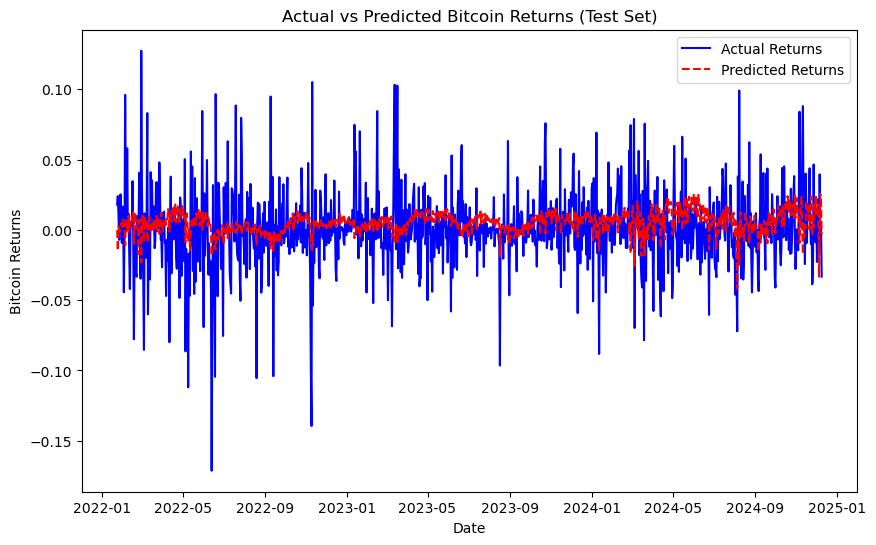

In [80]:
import pandas as pd
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# Assuming 'df' has a 'returns' column along with 'date', 'high', 'low'

# Split data into train and test (90% train, 10% test)
train_size = int(0.8 * len(df))  # Use 90% of data for training
train = df[:train_size]
test = df[train_size:]

# Prepare the training data (rename columns for Prophet)
df_train = train[['date', 'returns', 'high', 'low']].rename(columns={'date': 'ds', 'returns': 'y'})
df_train = df_train.sort_values('ds')
df_train = df_train.dropna()

# Prepare the test data (same format as the training data)
df_test = test[['date', 'returns', 'high', 'low']].rename(columns={'date': 'ds', 'returns': 'y'})
df_test = df_test.sort_values('ds')
df_test = df_test.dropna()

# Initialize Prophet model
model = Prophet()

# Add regressors: 'high' and 'low'
model.add_regressor('high')
model.add_regressor('low')

# Fit the model on the training data
model.fit(df_train)

# Get the last date of the training data
last_train_date = df_train['ds'].iloc[-1]

# Generate future dates (next len(df_test) days after the last train date)
future_dates = pd.date_range(last_train_date, periods=len(df_test)+1, freq='D')[1:]  # Skip the last date

# Create a future dataframe
future_test = pd.DataFrame({'ds': future_dates})

# Add the 'high' and 'low' values from the test set for the future dates
future_test['high'] = df_test['high'].values
future_test['low'] = df_test['low'].values

# Make predictions on the future data (test set)
forecast_test = model.predict(future_test)

# Get the predictions (yhat) for the test period
predictions = forecast_test['yhat']
actuals = df_test['y']

# Calculate RMSE (Root Mean Squared Error)
rmse = mean_squared_error(actuals, predictions, squared=False)
print(f'RMSE: {rmse}')

# Calculate MAE (Mean Absolute Error)
mae = mean_absolute_error(actuals, predictions)
print(f'MAE: {mae}')

# Plot actual vs predicted returns
plt.figure(figsize=(10, 6))
plt.plot(df_test['ds'], actuals, label='Actual Returns', color='blue')
plt.plot(df_test['ds'], predictions, label='Predicted Returns', color='red', linestyle='dashed')
plt.xlabel('Date')
plt.ylabel('Bitcoin Returns')
plt.title('Actual vs Predicted Bitcoin Returns (Test Set)')
plt.legend()
plt.show()


In [81]:
from sklearn.metrics import r2_score

# Calculate R-squared (R²)
r_squared = r2_score(actuals, predictions)
print(f'R-squared: {r_squared}')


R-squared: -0.08654003040511027
